In [16]:
import os.path as osp
import math
import json
from PIL import Image

import torch
import numpy as np
import cv2
import albumentations as A
from torch.utils.data import Dataset
from shapely.geometry import Polygon
import random
import matplotlib.pyplot as plt


def cal_distance(x1, y1, x2, y2):
    '''calculate the Euclidean distance'''
    return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)


def move_points(vertices, index1, index2, r, coef):
    '''move the two points to shrink edge
    Input:
        vertices: vertices of text region <numpy.ndarray, (8,)>
        index1  : offset of point1
        index2  : offset of point2
        r       : [r1, r2, r3, r4] in paper
        coef    : shrink ratio in paper
    Output:
        vertices: vertices where one edge has been shinked
    '''
    index1 = index1 % 4
    index2 = index2 % 4
    x1_index = index1 * 2 + 0
    y1_index = index1 * 2 + 1
    x2_index = index2 * 2 + 0
    y2_index = index2 * 2 + 1

    r1 = r[index1]
    r2 = r[index2]
    length_x = vertices[x1_index] - vertices[x2_index]
    length_y = vertices[y1_index] - vertices[y2_index]
    length = cal_distance(vertices[x1_index], vertices[y1_index], vertices[x2_index], vertices[y2_index])
    if length > 1:
        ratio = (r1 * coef) / length
        vertices[x1_index] += ratio * (-length_x)
        vertices[y1_index] += ratio * (-length_y)
        ratio = (r2 * coef) / length
        vertices[x2_index] += ratio * length_x
        vertices[y2_index] += ratio * length_y
    return vertices


def shrink_poly(vertices, coef=0.3):
    '''shrink the text region
    Input:
        vertices: vertices of text region <numpy.ndarray, (8,)>
        coef    : shrink ratio in paper
    Output:
        v       : vertices of shrinked text region <numpy.ndarray, (8,)>
    '''
    x1, y1, x2, y2, x3, y3, x4, y4 = vertices
    r1 = min(cal_distance(x1,y1,x2,y2), cal_distance(x1,y1,x4,y4))
    r2 = min(cal_distance(x2,y2,x1,y1), cal_distance(x2,y2,x3,y3))
    r3 = min(cal_distance(x3,y3,x2,y2), cal_distance(x3,y3,x4,y4))
    r4 = min(cal_distance(x4,y4,x1,y1), cal_distance(x4,y4,x3,y3))
    r = [r1, r2, r3, r4]

    # obtain offset to perform move_points() automatically
    if cal_distance(x1,y1,x2,y2) + cal_distance(x3,y3,x4,y4) > \
       cal_distance(x2,y2,x3,y3) + cal_distance(x1,y1,x4,y4):
        offset = 0 # two longer edges are (x1y1-x2y2) & (x3y3-x4y4)
    else:
        offset = 1 # two longer edges are (x2y2-x3y3) & (x4y4-x1y1)

    v = vertices.copy()
    v = move_points(v, 0 + offset, 1 + offset, r, coef)
    v = move_points(v, 2 + offset, 3 + offset, r, coef)
    v = move_points(v, 1 + offset, 2 + offset, r, coef)
    v = move_points(v, 3 + offset, 4 + offset, r, coef)
    return v


def get_rotate_mat(theta):
    '''positive theta value means rotate clockwise'''
    return np.array([[math.cos(theta), -math.sin(theta)], [math.sin(theta), math.cos(theta)]])


def rotate_vertices(vertices, theta, anchor=None):
    '''rotate vertices around anchor
    Input:
        vertices: vertices of text region <numpy.ndarray, (8,)>
        theta   : angle in radian measure
        anchor  : fixed position during rotation
    Output:
        rotated vertices <numpy.ndarray, (8,)>
    '''
    v = vertices.reshape((4,2)).T
    if anchor is None:
        anchor = v[:,:1]
    rotate_mat = get_rotate_mat(theta)
    res = np.dot(rotate_mat, v - anchor)
    return (res + anchor).T.reshape(-1)


def get_boundary(vertices):
    '''get the tight boundary around given vertices
    Input:
        vertices: vertices of text region <numpy.ndarray, (8,)>
    Output:
        the boundary
    '''
    x1, y1, x2, y2, x3, y3, x4, y4 = vertices
    x_min = min(x1, x2, x3, x4)
    x_max = max(x1, x2, x3, x4)
    y_min = min(y1, y2, y3, y4)
    y_max = max(y1, y2, y3, y4)
    return x_min, x_max, y_min, y_max


def cal_error(vertices):
    '''default orientation is x1y1 : left-top, x2y2 : right-top, x3y3 : right-bot, x4y4 : left-bot
    calculate the difference between the vertices orientation and default orientation
    Input:
        vertices: vertices of text region <numpy.ndarray, (8,)>
    Output:
        err     : difference measure
    '''
    x_min, x_max, y_min, y_max = get_boundary(vertices)
    x1, y1, x2, y2, x3, y3, x4, y4 = vertices
    err = cal_distance(x1, y1, x_min, y_min) + cal_distance(x2, y2, x_max, y_min) + \
          cal_distance(x3, y3, x_max, y_max) + cal_distance(x4, y4, x_min, y_max)
    return err


def find_min_rect_angle(vertices):
    '''find the best angle to rotate poly and obtain min rectangle
    Input:
        vertices: vertices of text region <numpy.ndarray, (8,)>
    Output:
        the best angle <radian measure>
    '''
    angle_interval = 1
    angle_list = list(range(-90, 90, angle_interval))
    area_list = []
    for theta in angle_list:
        rotated = rotate_vertices(vertices, theta / 180 * math.pi)
        x1, y1, x2, y2, x3, y3, x4, y4 = rotated
        temp_area = (max(x1, x2, x3, x4) - min(x1, x2, x3, x4)) * \
                    (max(y1, y2, y3, y4) - min(y1, y2, y3, y4))
        area_list.append(temp_area)

    sorted_area_index = sorted(list(range(len(area_list))), key=lambda k: area_list[k])
    min_error = float('inf')
    best_index = -1
    rank_num = 10
    # find the best angle with correct orientation
    for index in sorted_area_index[:rank_num]:
        rotated = rotate_vertices(vertices, angle_list[index] / 180 * math.pi)
        temp_error = cal_error(rotated)
        if temp_error < min_error:
            min_error = temp_error
            best_index = index
    return angle_list[best_index] / 180 * math.pi


def is_cross_text(start_loc, length, vertices):
    '''check if the crop image crosses text regions
    Input:
        start_loc: left-top position
        length   : length of crop image
        vertices : vertices of text regions <numpy.ndarray, (n,8)>
    Output:
        True if crop image crosses text region
    '''
    if vertices.size == 0:
        return False
    start_w, start_h = start_loc
    a = np.array([start_w, start_h, start_w + length, start_h, start_w + length, start_h + length,
                  start_w, start_h + length]).reshape((4, 2))
    p1 = Polygon(a).convex_hull
    for vertice in vertices:
        p2 = Polygon(vertice.reshape((4, 2))).convex_hull
        inter = p1.intersection(p2).area
        if 0.01 <= inter / p2.area <= 0.99:
            return True
    return False


def crop_img(img, vertices, labels, length):
    '''crop img patches to obtain batch and augment
    Input:
        img         : PIL Image
        vertices    : vertices of text regions <numpy.ndarray, (n,8)>
        labels      : 1->valid, 0->ignore, <numpy.ndarray, (n,)>
        length      : length of cropped image region
    Output:
        region      : cropped image region
        new_vertices: new vertices in cropped region
    '''
    h, w = img.height, img.width
    # confirm the shortest side of image >= length
    if h >= w and w < length:
        img = img.resize((length, int(h * length / w)), Image.BILINEAR)
    elif h < w and h < length:
        img = img.resize((int(w * length / h), length), Image.BILINEAR)
    ratio_w = img.width / w
    ratio_h = img.height / h
    assert(ratio_w >= 1 and ratio_h >= 1)

    new_vertices = np.zeros(vertices.shape)
    if vertices.size > 0:
        new_vertices[:,[0,2,4,6]] = vertices[:,[0,2,4,6]] * ratio_w
        new_vertices[:,[1,3,5,7]] = vertices[:,[1,3,5,7]] * ratio_h

    # find random position
    remain_h = img.height - length
    remain_w = img.width - length
    flag = True
    cnt = 0
    while flag and cnt < 1000:
        cnt += 1
        start_w = int(np.random.rand() * remain_w)
        start_h = int(np.random.rand() * remain_h)
        flag = is_cross_text([start_w, start_h], length, new_vertices[labels==1,:])
    box = (start_w, start_h, start_w + length, start_h + length)
    region = img.crop(box)
    if new_vertices.size == 0:
        return region, new_vertices

    new_vertices[:,[0,2,4,6]] -= start_w
    new_vertices[:,[1,3,5,7]] -= start_h
    return region, new_vertices


def rotate_all_pixels(rotate_mat, anchor_x, anchor_y, length):
    '''get rotated locations of all pixels for next stages
    Input:
        rotate_mat: rotatation matrix
        anchor_x  : fixed x position
        anchor_y  : fixed y position
        length    : length of image
    Output:
        rotated_x : rotated x positions <numpy.ndarray, (length,length)>
        rotated_y : rotated y positions <numpy.ndarray, (length,length)>
    '''
    x = np.arange(length)
    y = np.arange(length)
    x, y = np.meshgrid(x, y)
    x_lin = x.reshape((1, x.size))
    y_lin = y.reshape((1, x.size))
    coord_mat = np.concatenate((x_lin, y_lin), 0)
    rotated_coord = np.dot(rotate_mat, coord_mat - np.array([[anchor_x], [anchor_y]])) + \
                                                   np.array([[anchor_x], [anchor_y]])
    rotated_x = rotated_coord[0, :].reshape(x.shape)
    rotated_y = rotated_coord[1, :].reshape(y.shape)
    return rotated_x, rotated_y


def resize_img(img, vertices, size):
    h, w = img.height, img.width
    ratio = size / max(h, w)
    if w > h:
        img = img.resize((size, int(h * ratio)), Image.BILINEAR)
    else:
        img = img.resize((int(w * ratio), size), Image.BILINEAR)
    new_vertices = vertices * ratio
    return img, new_vertices


def adjust_height(img, vertices, ratio=0.2):
    '''adjust height of image to aug data
    Input:
        img         : PIL Image
        vertices    : vertices of text regions <numpy.ndarray, (n,8)>
        ratio       : height changes in [0.8, 1.2]
    Output:
        img         : adjusted PIL Image
        new_vertices: adjusted vertices
    '''
    ratio_h = 1 + ratio * (np.random.rand() * 2 - 1)
    old_h = img.height
    new_h = int(np.around(old_h * ratio_h))
    img = img.resize((img.width, new_h), Image.BILINEAR)

    new_vertices = vertices.copy()
    if vertices.size > 0:
        new_vertices[:,[1,3,5,7]] = vertices[:,[1,3,5,7]] * (new_h / old_h)
    return img, new_vertices


def rotate_img(img, vertices, angle_range=10):
    '''rotate image [-10, 10] degree to aug data
    Input:
        img         : PIL Image
        vertices    : vertices of text regions <numpy.ndarray, (n,8)>
        angle_range : rotate range
    Output:
        img         : rotated PIL Image
        new_vertices: rotated vertices
    '''
    center_x = (img.width - 1) / 2
    center_y = (img.height - 1) / 2
    angle = angle_range * (np.random.rand() * 2 - 1)
    img = img.rotate(angle, Image.BILINEAR)
    new_vertices = np.zeros(vertices.shape)
    for i, vertice in enumerate(vertices):
        new_vertices[i,:] = rotate_vertices(vertice, -angle / 180 * math.pi, np.array([[center_x],[center_y]]))
    return img, new_vertices


def generate_roi_mask(image, vertices, labels):
    mask = np.ones(image.shape[:2], dtype=np.float32)
    ignored_polys = []
    for vertice, label in zip(vertices, labels):
        if label == 0:
            ignored_polys.append(np.around(vertice.reshape((4, 2))).astype(np.int32))
    cv2.fillPoly(mask, ignored_polys, 0)
    return mask


def filter_vertices(vertices, labels, ignore_under=0, drop_under=0):
    if drop_under == 0 and ignore_under == 0:
        return vertices, labels

    new_vertices, new_labels = vertices.copy(), labels.copy()

    areas = np.array([Polygon(v.reshape((4, 2))).convex_hull.area for v in vertices])
    labels[areas < ignore_under] = 0

    if drop_under > 0:
        passed = areas >= drop_under
        new_vertices, new_labels = new_vertices[passed], new_labels[passed]

    return new_vertices, new_labels

def rotate(x1, y1, x0, y0, a): # rotate point p1 around p0 by angle a
    x2 = ((x1 - x0) * math.cos(a)) - ((y1 - y0) * math.sin(a)) + x0
    y2 = ((x1 - x0) * math.sin(a)) + ((y1 - y0) * math.cos(a)) + y0
    return (x2, y2)

class SceneTextDataset(Dataset):
    def __init__(self, root_dir,
                 split='train',
                 image_size=2048,
                 crop_size=1024,
                 ignore_tags=[],
                 ignore_under_threshold=10,
                 drop_under_threshold=1,
                 color_jitter=False,
                 normalize=False,
                 cutmix=True,
                 label_resize_p = 1.0,
                 elastic=True,
                 gray=True):
        with open(osp.join(root_dir, 'ufo/{}.json'.format(split)), 'r') as f:
            anno = json.load(f)

        self.anno = anno
        self.image_fnames = sorted(anno['images'].keys())
        self.image_dir = osp.join(root_dir, 'img', 'train')

        self.image_size, self.crop_size = image_size, crop_size
        self.color_jitter, self.normalize = color_jitter, normalize
        self.cutmix = cutmix
        self.label_resize_p = label_resize_p
        self.elastic = elastic
        self.gray = gray

        self.ignore_tags = ignore_tags

        self.drop_under_threshold = drop_under_threshold
        self.ignore_under_threshold = ignore_under_threshold

    def __len__(self):
        return len(self.image_fnames)

    def __getitem__(self, idx):
        image_fname = self.image_fnames[idx]
        image_fpath = osp.join(self.image_dir, image_fname)

        vertices, labels = [], []
        for word_info in self.anno['images'][image_fname]['words'].values():
            word_tags = word_info['tags']

            ignore_sample = any(elem for elem in word_tags if elem in self.ignore_tags)
            num_pts = np.array(word_info['points']).shape[0]

            # skip samples with ignore tag and
            # samples with number of points greater than 4
            if ignore_sample or num_pts > 4:
                continue

            vertices.append(np.array(word_info['points']).flatten())
            labels.append(int(not word_info['illegibility']))
        vertices, labels = np.array(vertices, dtype=np.float32), np.array(labels, dtype=np.int64)

        vertices, labels = filter_vertices(
            vertices,
            labels,
            ignore_under=self.ignore_under_threshold,
            drop_under=self.drop_under_threshold
        )

        image = Image.open(image_fpath)
        image, vertices = resize_img(image, vertices, self.image_size)
        image, vertices = adjust_height(image, vertices)
        image, vertices = rotate_img(image, vertices)
        image, vertices = crop_img(image, vertices, labels, self.crop_size)

        if image.mode != 'RGB':
            image = image.convert('RGB')
        image = np.array(image)

        funcs = []

        # Style Transformation
        if self.color_jitter:
            funcs.append(A.ColorJitter(0.5, 0.5, 0.5, 0.25))
        if self.normalize:
            funcs.append(A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)))
        if self.elastic:
            funcs.append(A.ElasticTransform(alpha=1, sigma=50, alpha_affine=0, interpolation=1, border_mode=4, p=1.0))
        if self.gray:
            funcs.append(A.ToGray(p=1.0))
        transform = A.Compose(funcs)
        
        image = transform(image=image)['image']
        word_bboxes = np.reshape(vertices, (-1, 4, 2))
    
        #Geometric Transformation
        if self.cutmix:
            small_box = []
            image_cloned = image.copy()
            try:
                for i in word_bboxes:
                    point1 = np.array(i, np.int32)
                    max = np.max(point1, axis=0)
                    min = np.min(point1, axis=0)
                    small_box.append((max, min)) 
                
                for x in random.sample(small_box, 10):
                    random_x1 = random.randrange(100, 800)
                    random_y1 = random.randrange(100, 800)
                    
                    max_x = x[0][0].item()
                    max_y = x[0][1].item()
                    min_x = x[1][0].item()
                    min_y = x[1][1].item()
                    
                    if np.max([min_x, max_x, min_y, max_y]) > 1024 or np.min([min_x, max_x, min_y, max_y]) < 0: # 짤린 label 제거
                        continue
                    
                    width = round(max_x - min_x)
                    height = round(max_y - min_y)
                    if (height >= width):
                        dst = image_cloned[min_y-1:max_y+1, min_x-1:max_x+1]
                        if random.random() <= self.label_resize_p:
                            dst = cv2.resize(dst, dsize=(25, 25), interpolation=cv2.INTER_AREA)
                        shape = dst.shape

                        dst = cv2.rotate(dst, cv2.ROTATE_90_COUNTERCLOCKWISE)
                        
                        word_bboxes_vertices = np.array([[random_y1, random_x1],
                                                        [random_y1+shape[1], random_x1],
                                                        [random_y1+shape[1], random_x1+shape[0]],
                                                        [random_y1, random_x1+shape[0]]])
                                                        
                        word_bboxes_vertices = np.reshape(word_bboxes_vertices, (8,))
                        word_bboxes_vertices = rotate_vertices(word_bboxes_vertices, -1.57)

                        word_bboxes_vertices_a = np.reshape(word_bboxes_vertices, (4,2))
                        max = np.max(word_bboxes_vertices_a, axis=0).astype(int)
                        min = np.min(word_bboxes_vertices_a, axis=0).astype(int)
                        
                        image_cloned[min[1]:max[1], min[0]:max[0]] = dst # y, x format
                        vertices = np.concatenate((vertices,[word_bboxes_vertices]), axis=0)
                        
                        image = image_cloned.copy()
                    else:
                        dst = image_cloned[min_y-1:max_y+1, min_x-1:max_x+1] # bounding box region
                        if random.random() <= self.label_resize_p:
                            dst = cv2.resize(dst, dsize=(150, 50), interpolation=cv2.INTER_AREA) 
                        shape = dst.shape

                        dst = cv2.rotate(dst, cv2.ROTATE_90_COUNTERCLOCKWISE)
                        word_bboxes_vertices = np.array([[random_y1, random_x1],
                                                        [random_y1+shape[1], random_x1],
                                                        [random_y1+shape[1], random_x1+shape[0]],
                                                        [random_y1, random_x1+shape[0]]])
                    
                        word_bboxes_vertices = np.reshape(word_bboxes_vertices, (8,))
                        word_bboxes_vertices = rotate_vertices(word_bboxes_vertices, -1.57)

                        word_bboxes_vertices_a = np.reshape(word_bboxes_vertices, (4,2))
                        max = np.max(word_bboxes_vertices_a, axis=0).astype(int)
                        min = np.min(word_bboxes_vertices_a, axis=0).astype(int)
                        
                        image_cloned[min[1]:max[1], min[0]:max[0]] = dst # y, x format
                        vertices = np.concatenate((vertices,[word_bboxes_vertices]), axis=0)

                        image = image_cloned.copy()
            except: 
                pass
        
        word_bboxes = np.reshape(vertices, (-1, 4, 2))
        roi_mask = generate_roi_mask(image, vertices, labels)

        return image, word_bboxes, roi_mask

In [17]:
train_dataset = SceneTextDataset(
        root_dir= '/opt/ml/level2_cv_datacentric-cv-07/data/medical',
        split='new_anno_301',
        image_size=2048,
        crop_size=1024,
        ignore_tags=['masked', 'excluded-region', 'maintable', 'stamp']
    )

In [18]:
image, word_bboxes, roi_mask = next(iter(train_dataset))

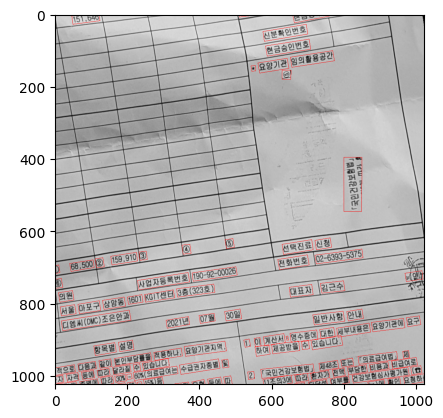

In [19]:
for i in word_bboxes:
    point1 = np.array(i, np.int32)
    image = cv2.polylines(image, [point1], isClosed=True, color=(255,0,0)) # red  

plt.imshow(image)